# Análisis de Evasión de Clientes (Churn)

## Introducción
El objetivo de este análisis es comprender los factores que influyen en la evasión de clientes (*churn*) en la empresa **Telecom X**.
A través de técnicas de limpieza, transformación y análisis exploratorio de datos, se buscan identificar patrones que permitan
proponer estrategias para reducir la pérdida de clientes.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## 1. Carga de Datos

Los datos se cargan desde un archivo JSON que simula una API, el cual contiene información demográfica,
de servicios contratados, facturación y estado de evasión de los clientes.

In [4]:
df = pd.read_json("TelecomX_Data.json")
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2. Comprensión de la Estructura del Dataset

El dataset contiene múltiples columnas anidadas que deben ser normalizadas para facilitar el análisis.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


## 3. Limpieza y Tratamiento de Datos

Se normalizan las columnas anidadas (`customer`, `phone`, `internet`, `account`) y se corrigen
problemas de tipos de datos y valores ausentes.

In [6]:
customer_df = pd.json_normalize(df["customer"])
phone_df = pd.json_normalize(df["phone"])
internet_df = pd.json_normalize(df["internet"])
account_df = pd.json_normalize(df["account"])

df = pd.concat(
    [
        df.drop(columns=["customer", "phone", "internet", "account"]),
        customer_df,
        phone_df,
        internet_df,
        account_df
    ],
    axis=1
)

df["Charges.Total"] = pd.to_numeric(df["Charges.Total"], errors="coerce")

df["Churn"] = df["Churn"].replace("", pd.NA)
df = df.dropna(subset=["Churn"])

binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40


## 4. Feature Engineering

Se crea la variable **Cuentas_Diarias**, calculada a partir del cargo mensual, para obtener
una visión más detallada del gasto diario de los clientes.

In [7]:
df["Cuentas_Diarias"] = df["Charges.Monthly"] / 30
df[["Charges.Monthly", "Cuentas_Diarias"]].head()

,Charges.Monthly,Cuentas_Diarias
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667


## 5. Análisis Descriptivo

Se calculan métricas estadísticas básicas para comprender la distribución general de los datos.

In [8]:
df.describe()

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.265370,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2283.300441,2.158723
std,0.441561,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2266.771362,1.003002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,401.450000,1.183333
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,2.345000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3794.737500,2.995000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,3.958333


## 6. Distribución de la Evasión (Churn)

Se analiza la proporción de clientes que abandonaron el servicio frente a los que permanecieron.

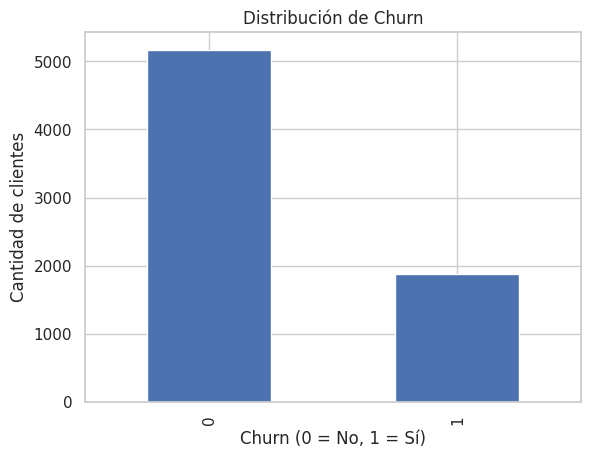

In [9]:
plt.figure()
df["Churn"].value_counts().plot(kind="bar")
plt.title("Distribución de Churn")
plt.xlabel("Churn (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de clientes")
plt.show()

## 7. Churn según Variables Categóricas

Se explora cómo la evasión varía según el tipo de contrato y otras variables categóricas.

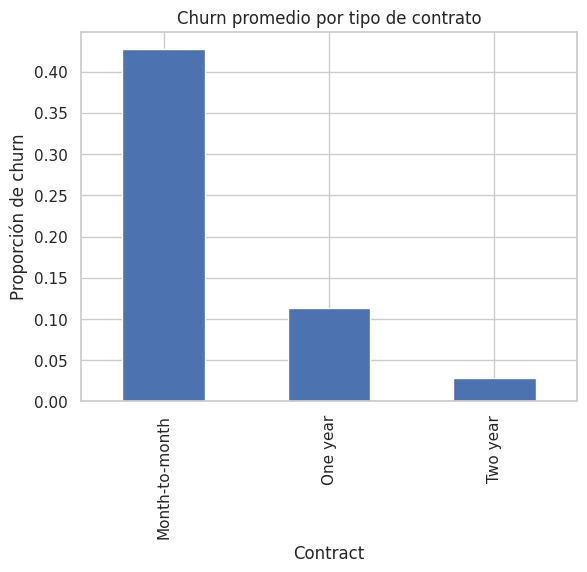

In [10]:
contract_churn = df.groupby("Contract")["Churn"].mean()

plt.figure()
contract_churn.plot(kind="bar")
plt.title("Churn promedio por tipo de contrato")
plt.ylabel("Proporción de churn")
plt.show()

## 8. Churn según Variables Numéricas

Se comparan variables numéricas clave entre clientes que churnearon y los que no.

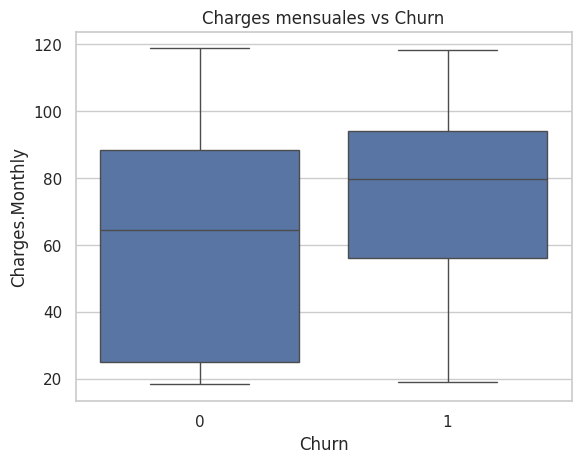

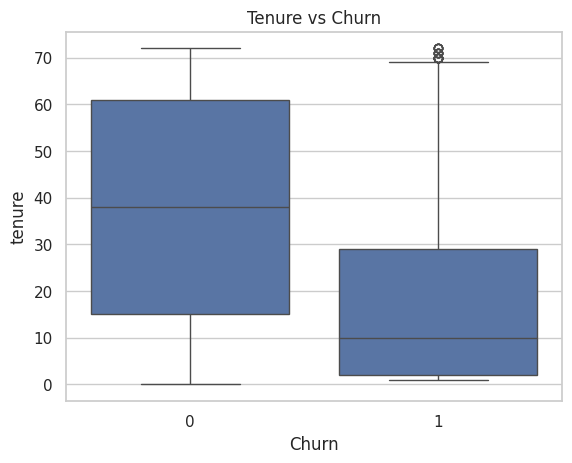

In [11]:
plt.figure()
sns.boxplot(x="Churn", y="Charges.Monthly", data=df)
plt.title("Charges mensuales vs Churn")
plt.show()

plt.figure()
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()

## 9. Análisis de Correlación

Se analizarón las correlaciones entre variables numéricas para identificar relaciones relevantes
con la evasión de clientes.

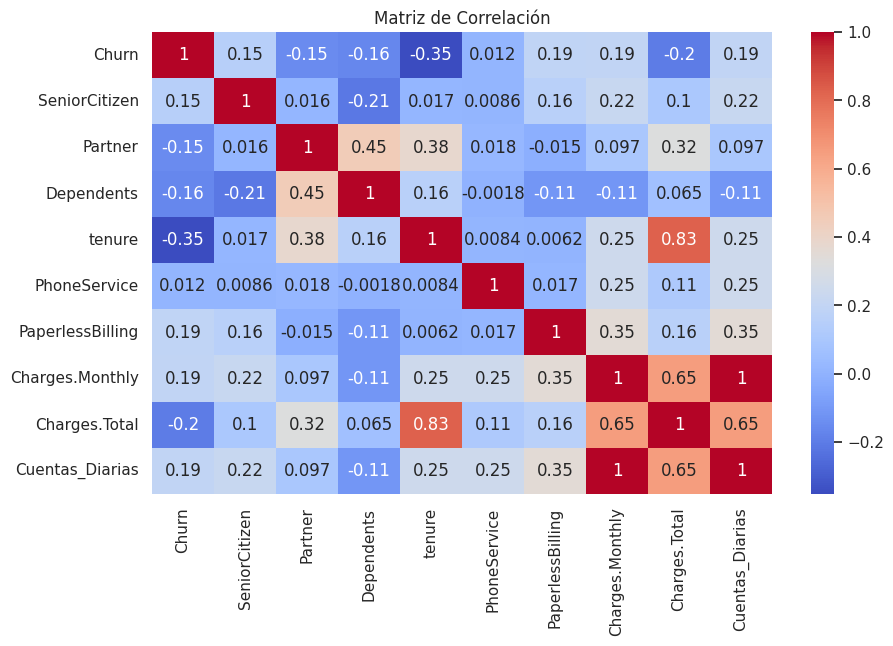

In [12]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Confusión")
plt.show()

## 10. Conclusiones e Insights

- La evasión es significativamente mayor en contratos *month-to-month*.
- Clientes con menor **tenure** presentan mayor probabilidad de churn.
- Cargos mensuales altos están asociados a mayor evasión.
- Los contratos de largo plazo reducen considerablemente el churn.

## 11. Recomendaciones

- Incentivar contratos de uno y dos años.
- Implementar estrategias de retención temprana para clientes nuevos.
- Monitorear clientes con cargos elevados y contratos cortos.
